# Examining circuit statistics while accounting for null circuit

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
import os
import corner
import sys
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.utils.misc.numerical import count_monotonic_group_lengths, find_monotonic_group_idxs, is_within_range
from synbio_morpher.utils.misc.string_handling import string_to_tuple_list
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from synbio_morpher.utils.misc.type_handling import flatten_listlike, get_first_elements
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.common.testing.shared import CONFIG

SEQ_LENGTH = 20
config = deepcopy(CONFIG)

In [16]:
fn = '../data/ensemble_mutation_effect_analysis/2023_04_11_192013/summarise_simulation/tabulated_mutation_info.csv'
info = pd.read_csv(fn)

## Process summary

### Define new fields

Define distance metric to robust adaptation region

In [17]:
info['sp_distance'] = 0 
info.loc[(info['sensitivity_wrt_species-6'] <= 1) & (info['precision_wrt_species-6'] <= 10), 'sp_distance'] = np.sqrt(
    np.power(1-info['sensitivity_wrt_species-6'], 2) + np.power(10 - info['precision_wrt_species-6'], 2))
info.loc[(info['sensitivity_wrt_species-6'] <= 1) & (info['precision_wrt_species-6'] > 10), 'sp_distance'] = np.absolute(info['sensitivity_wrt_species-6'] - 1)
info.loc[(info['sensitivity_wrt_species-6'] > 1) & (info['precision_wrt_species-6'] <= 10), 'sp_distance'] = np.absolute(info['precision_wrt_species-6'] - 10)


Mutation binding site groups and locations

In [18]:
num_group_cols = [e.replace('energies', 'binding_sites_groups') for e in get_true_interaction_cols(info, 'energies')]
num_bs_cols = [e.replace('energies', 'binding_sites_count') for e in get_true_interaction_cols(info, 'energies')]
bs_idxs_cols = [e.replace('energies', 'binding_sites_idxs') for e in get_true_interaction_cols(info, 'energies')]
bs_range_cols = [e.replace('energies', 'binding_site_group_range') for e in get_true_interaction_cols(info, 'energies')]

for b, g, bs, bsi, r in zip(get_true_interaction_cols(info, 'binding_sites'), num_group_cols, num_bs_cols, bs_idxs_cols, bs_range_cols):
    fbs = [string_to_tuple_list(bb) for bb in info[b]]
    first = get_first_elements(fbs, empty_replacement=[])
    info[bs] = [count_monotonic_group_lengths(bb) for bb in first]
    info[bsi] = [find_monotonic_group_idxs(bb) for bb in first]
    info[g] = info[bs].apply(len)
    info[r] = [[(bb[0], bb[-1]) for bb in b] for b in info[bsi]]

Mutation number ratiometric change:

In [19]:
numerical_cols = [c for c in info.columns if (type(info[(info['mutation_num'] > 0) & (info['eqconstants_0-0'] > 1)][c].iloc[0]) != str) and (type(info[c].iloc[0]) != list) and c not in get_true_interaction_cols(info, 'binding_sites')]
key_cols = ['circuit_name', 'interacting', 'mutation_name', 'name', 'sample_name']

# Group by 'name'
grouped = info.groupby(['circuit_name', 'sample_name'], as_index=False)

# Subtract the values from the zero row from each group
mutation_log = grouped[numerical_cols].apply(lambda x: np.log(x / x.loc[x['mutation_num'] == 0].squeeze()))
mutation_log['mutation_num'] = info['mutation_num']
mutation_log['RMSE'] = info['RMSE']
mutation_log['sp_distance'] = info['sp_distance']
for c in key_cols:
    mutation_log[c] = info[c]

/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/tmp/ipykernel_92892/489350077.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  mutation_log = grouped[numerical_cols].apply(lambda x: np.log(x / x.loc[x['mutation_num'] == 0].squeeze()))


### Expand DataFrames

Melt energies:

In [20]:
good_cols = list(info.columns)
[good_cols.remove(x) for x in get_true_interaction_cols(info, 'binding_rates_dissociation') + get_true_interaction_cols(info, 'eqconstants') +
 get_true_interaction_cols(info, 'energies') + get_true_interaction_cols(info, 'binding_sites') + num_group_cols + num_bs_cols]
good_cols

binding_idx_map = {e.replace('energies_', ''): i for i, e in enumerate(get_true_interaction_cols(info, 'energies'))}


In [21]:
infom = info.melt(good_cols, value_vars=get_true_interaction_cols(info, 'energies'), var_name='energies_idx', value_name='energies')
dfm = info.melt(good_cols, value_vars=num_group_cols, var_name='num_groups_idx', value_name='num_groups')
infom['idx_species_binding'] = dfm['num_groups_idx'].apply(lambda x: binding_idx_map[x.replace('binding_sites_groups_', '')])
infom['num_groups'] = dfm['num_groups']
dfm = info.melt(good_cols, value_vars=num_bs_cols, var_name='num_bs_idx', value_name='num_bs')
infom['num_bs'] = dfm['num_bs']

for k in ['binding_sites', 'binding_rates_dissociation', 'eqconstants']:
    dfm = info.melt(good_cols, value_vars=get_true_interaction_cols(info, k), var_name=f'{k}_idx', value_name=k)
    infom[k] = dfm[k]

Melt mutation logs:

In [22]:
mutation_cols = [c for c in numerical_cols + key_cols if c not in get_true_interaction_cols(mutation_log, 'energies') +
                 get_true_interaction_cols(mutation_log, 'binding_rates_dissociation') +
                 get_true_interaction_cols(mutation_log, 'eqconstants') +
                 get_true_interaction_cols(mutation_log, 'binding_sites_groups')]
mutation_logm = mutation_log.melt(mutation_cols, value_vars=get_true_interaction_cols(mutation_log, 'energies'), var_name='energies_idx', value_name='energies')

for k in ['binding_rates_dissociation', 'eqconstants', 'binding_sites_groups']:
    dfm = mutation_log.melt(mutation_cols, value_vars=get_true_interaction_cols(mutation_log, k), var_name=f'{k}_idx', value_name=k)
    mutation_logm[k] = dfm[k]
    
for c in ['idx_species_binding', 'num_groups', 'num_bs']:
    mutation_logm[c] = infom[c]

Energy diffs

In [23]:
for k in ['binding_rates_dissociation', 'eqconstants', 'energies']:
    infom[f'{k}_diffs'] = info.groupby(['circuit_name'])[get_true_interaction_cols(info, f'{k}')].apply(lambda x: x - x.iloc[0]).melt(value_vars=get_true_interaction_cols(info, f'{k}'), var_name='idx', value_name=f'{k}_diffs')[f'{k}_diffs']
    mutation_logm[f'{k}_diffs'] = mutation_log.groupby(['circuit_name'])[get_true_interaction_cols(mutation_log, f'{k}')].apply(lambda x: x - x.iloc[0]).melt(value_vars=get_true_interaction_cols(mutation_log, f'{k}'), var_name='idx', value_name=f'{k}_diffs')[f'{k}_diffs']


/tmp/ipykernel_92892/1812372253.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  infom[f'{k}_diffs'] = info.groupby(['circuit_name'])[get_true_interaction_cols(info, f'{k}')].apply(lambda x: x - x.iloc[0]).melt(value_vars=get_true_interaction_cols(info, f'{k}'), var_name='idx', value_name=f'{k}_diffs')[f'{k}_diffs']
/tmp/ipykernel_92892/1812372253.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_key

### STD's

In [24]:
relevant_cols = [
    'fold_change', 
    # 'initial_steady_states', 
    # 'max_amount', 'min_amount',
    'overshoot', 
    'RMSE', 
    'steady_states', 
    'response_time_wrt_species-6',
    # 'response_time_wrt_species-6_diff_to_base_circuit',
    # 'response_time_wrt_species-6_ratio_from_mutation_to_base',
    'precision_wrt_species-6',
    'precision_wrt_species-6_diff_to_base_circuit',
    'precision_wrt_species-6_ratio_from_mutation_to_base',
    'sensitivity_wrt_species-6',
    'sensitivity_wrt_species-6_diff_to_base_circuit',
    'sensitivity_wrt_species-6_ratio_from_mutation_to_base',
    'fold_change_diff_to_base_circuit',
    # 'initial_steady_states_diff_to_base_circuit',
    # 'max_amount_diff_to_base_circuit', 'min_amount_diff_to_base_circuit',
    'overshoot_diff_to_base_circuit', 
    # 'RMSE_diff_to_base_circuit',
    'steady_states_diff_to_base_circuit',
    'fold_change_ratio_from_mutation_to_base',
    # 'initial_steady_states_ratio_from_mutation_to_base',
    # 'max_amount_ratio_from_mutation_to_base',
    # 'min_amount_ratio_from_mutation_to_base',
    # 'overshoot_ratio_from_mutation_to_base',
    # 'RMSE_ratio_from_mutation_to_base',
    'steady_states_ratio_from_mutation_to_base', 
    # 'num_groups',
    'energies', 
    'binding_rates_dissociation',
    'eqconstants',
    'energies_diffs', 
    'binding_rates_dissociation_diffs',
    'eqconstants_diffs'
    ]

named_aggs = {}
for c in relevant_cols:
    named_aggs.update({c + '_std': pd.NamedAgg(column=c, aggfunc="std")})
    named_aggs.update({c + '_mean': pd.NamedAgg(column=c, aggfunc="mean")})
    named_aggs.update({c + '_std_normed_by_mean': pd.NamedAgg(column=c, aggfunc=lambda x: np.std(x) / np.max([1, np.mean(x)]))})
info_summ = infom.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg(**named_aggs)
    # {c: [np.std, np.mean, lambda x: np.std(x) / np.mean(x)] for c in relevant_cols})
mut_summ = mutation_logm.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg(**named_aggs)


In [25]:
stop

NameError: name 'stop' is not defined

# Visualisations

In [ ]:
sns.histplot(mutation_log, x='fold_change', hue='mutation_num', log_scale=[False, True], element='step', bins=100)


In [ ]:

sns.histplot(mutation_logm, x='binding_rates_dissociation', hue='mutation_num', element='step', log_scale=[False, True], bins = 100)
plt.title('Ratiometric change from reference to mutated circuit')

In [ ]:
fig = px.scatter_3d(
    mutation_log,
    x='sensitivity_wrt_species-6', y='precision_wrt_species-6', z='sp_distance', 
    color='mutation_num')
fig.show()

Histogram 3D

In [ ]:
import plotly.graph_objects as go

xv = np.array(
    mutation_log['sensitivity_wrt_species-6']
)
yv = np.array(
    mutation_log['precision_wrt_species-6']
)
h = np.histogram2d(xv, yv, bins=50)


def bin_centers(bins):
    centers = (bins + (bins[1]-bins[0])/2)[:-1]
    return centers


x_bins_centers = bin_centers(h[1])
y_bins_centers = bin_centers(h[2])
x_bins_centers = h[1][:-1]
y_bins_centers = h[2][:-1]

df = pd.DataFrame(np.log(h[0]), index=x_bins_centers, columns=y_bins_centers)
fig = go.Figure(data=[go.Surface(z=df)])
# fig.update_zaxes(type="log")
fig.show()

## Mutational disruption

Expand the mutation positions and types from lists in each cell to distribute list values over rows.

In [ ]:

info_summ = mutation_logm.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg(**named_aggs)

info['mutation_type'] = info['mutation_type'].str.strip('[]').str.split(',').apply(lambda x: [int(xx) for xx in x if xx])
info['mutation_positions'] = info['mutation_positions'].str.strip('[]').str.split(',').apply(lambda x: [int(xx) for xx in x if xx])

info_e = info.explode(column=['mutation_type', 'mutation_positions'])

mut_in_bs_cols = [e.replace('energies', 'is_mutation_in_binding_site') for e in get_true_interaction_cols(info, 'energies')]
for isb, r in zip(mut_in_bs_cols, bs_range_cols):
    info_e[isb] = [any([is_within_range(m, r) for r in range_tuples]) for m, range_tuples in zip(info_e['mutation_positions'], info_e[r])]

mut_in_edge_cols = [e.replace('energies', 'is_mutation_on_edge') for e in get_true_interaction_cols(info, 'energies')]
for ise, r in zip(mut_in_edge_cols, bs_range_cols):
    info_e[ise] = [any([(m == r[0]) or (m == r[-1]) for r in range_tuples]) for m, range_tuples in zip(info_e['mutation_positions'], info_e[r])]

info_e[(info_e[isb] == True) & (info_e['mutation_num'] == 0)][['mutation_positions', isb, r]]

infom['frac_muts_in_binding_site'] = info_e.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({isb: lambda x: sum(x) / np.max([1, len(x)]) for isb in mut_in_bs_cols}).melt(
    id_vars=['circuit_name', 'mutation_num', 'sample_name'], value_vars=mut_in_bs_cols, var_name='idx', value_name='frac_muts_in_binding_site')['frac_muts_in_binding_site']

sns.jointplot(infom[infom['mutation_num'] > 0], x='frac_muts_in_binding_site', y='energies', hue='mutation_num')



Mutation corner

In [ ]:
# corner_cols = [c for c in mutation_logm.columns if ('diff_to_base_circuit' not in c) and ('ratio_from_mutation' not in c) and ('name' not in c) and ('idx' not in c)]
# corner_cols.remove('num_bs')
# corner_cols.remove('num_groups')
# corner_cols.remove('final_deriv')
# corner_cols.remove('energies')
# corner_cols.remove('energies_diffs')
# corner_cols.remove('num_interacting')
# corner_cols.remove('num_self_interacting')
# corner_cols.remove('binding_sites_groups')
# corner_cols.remove('interacting')
# corner_cols.remove(corner_cols[5])
# corner_cols

# temp = mutation_logm[(mutation_logm['sample_name'] != 'RNA_0') & (mutation_logm['precision_wrt_species-6'] != np.inf) & (mutation_logm['precision_wrt_species-6_diff_to_base_circuit'] != -np.inf)][corner_cols]
# fig = corner.corner(temp, labels=corner_cols, show_titles=True, title_kwargs={"fontsize": 12}, color='b')


## Removing null circuit

In [ ]:
null_circuit = infom.groupby(['circuit_name', 'mutation_name'], as_index=False).agg({'energies': 'mean'})
null_circuit = null_circuit[(null_circuit['energies'] == 0)].iloc[0] 
null_circuit = infom[(infom['circuit_name'] == null_circuit['circuit_name']) & (infom['mutation_name'] == null_circuit['mutation_name'])]

info_null = deepcopy(infom)
sample_names = info['sample_name'].unique()
for s in sample_names:
    for c in relevant_cols:
        info_null.loc[info_null['sample_name'] == s, c] = np.log(info_null[info_null['sample_name']
                                                                           == s][c] / null_circuit[null_circuit['sample_name'] == s][c].values[0])

for c in relevant_cols:
    infom[c + '_null'] = info_null[c]

info_summ_null = info_null.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg(**named_aggs)


/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Visualisations without null circuit


What does the null circuit look like?

In [ ]:
pd.options.display.max_columns = 50

null_circuit['sensitivity_wrt_species-6'].iloc[:3]

330    1.000000
331    0.104064
332    0.104064
Name: sensitivity_wrt_species-6, dtype: float64

In [ ]:
inf = infom[infom['energies_idx'] == 'energies_0-0']
m = mutation_logm[infom['energies_idx'] == 'energies_0-0']

/tmp/ipykernel_55377/2211026009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inf['sp_null_change'] = inf['sensitivity_wrt_species-6' + '_null'] * inf['precision_wrt_species-6' + '_null']


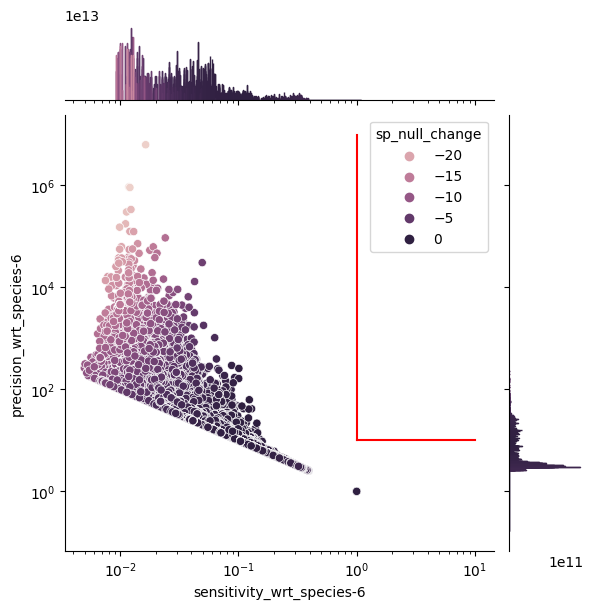

In [ ]:
# %%
inf['sp_null_change'] = inf['sensitivity_wrt_species-6' + '_null'] * inf['precision_wrt_species-6' + '_null'] 
sns.jointplot(inf, x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='sp_null_change')
plt.xscale('log')
plt.yscale('log')

plt.plot(np.ones(100), np.linspace(10, 1e7, 100), color='r')
plt.plot(np.linspace(1, 10, 40), np.ones(40) * 10, color='r')

# %%
# sns.histplot(mutation_log, x='sensitivity_wrt_species-6', hue='mutation_num', log_scale=[False, True], element='step', bins=100)
# sns.histplot(infom[infom['energies_idx'] == 'energies_0-0'], x='sensitivity_wrt_species-6' + '_null', hue='mutation_num', log_scale=[False, True], element='step')


/tmp/ipykernel_86576/2171213170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inf['sp_mut_change'] = m['sensitivity_wrt_species-6'] * m['precision_wrt_species-6']


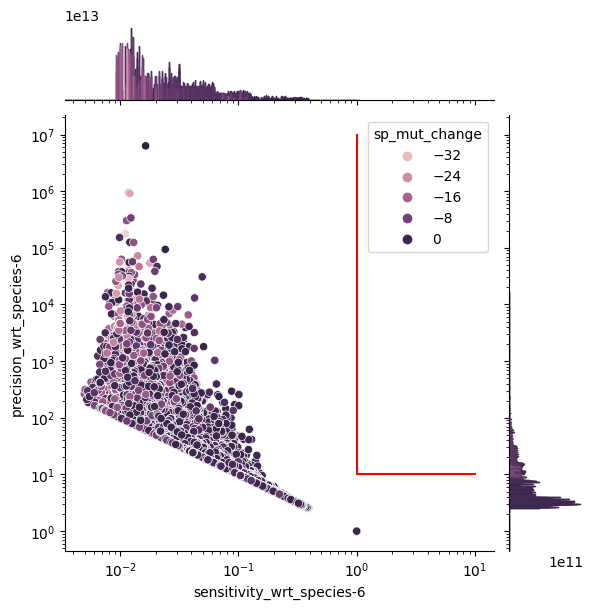

In [ ]:
inf['sp_mut_change'] = m['sensitivity_wrt_species-6'] * m['precision_wrt_species-6'] 
sns.jointplot(inf, x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='sp_mut_change')
plt.xscale('log')
plt.yscale('log')

plt.plot(np.ones(100), np.linspace(10, 1e7, 100), color='r')
plt.plot(np.linspace(1, 10, 40), np.ones(40) * 10, color='r')
# plt.xlabel('Sensitivity log mutation difference')


A lot of the circuits behave like the null circuit:

<AxesSubplot: xlabel='sensitivity_wrt_species-6_null', ylabel='Count'>

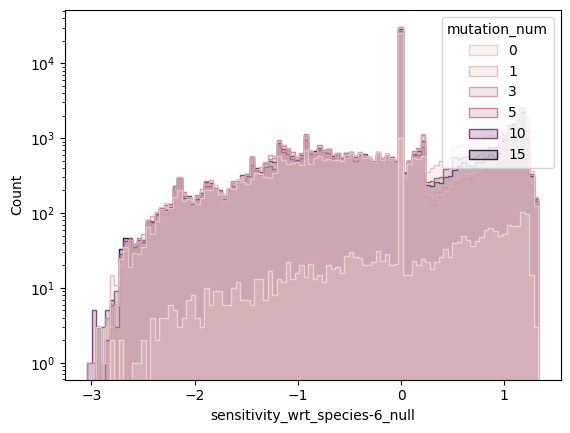

In [ ]:

sns.histplot(inf, x='sensitivity_wrt_species-6' + '_null', hue='mutation_num', log_scale=[False, True], element='step', bins=100)


In [ ]:
print('Fraction that are like null for sensitivity')
print('Within 0.1: ', str(
sum(np.abs(inf['sensitivity_wrt_species-6' + '_null']) < 0.1) / len(inf['sensitivity_wrt_species-6' + '_null'])
))
print('Equal to null circuit: ', str(
sum(inf['sensitivity_wrt_species-6' + '_null'] == 0) / len(inf['sensitivity_wrt_species-6' + '_null'])
))

Fraction that are like null for sensitivity
Within 0.1:  0.4145206611570248
Equal to null circuit:  0.3870358126721763


Null for Sensitivity vs. Precision

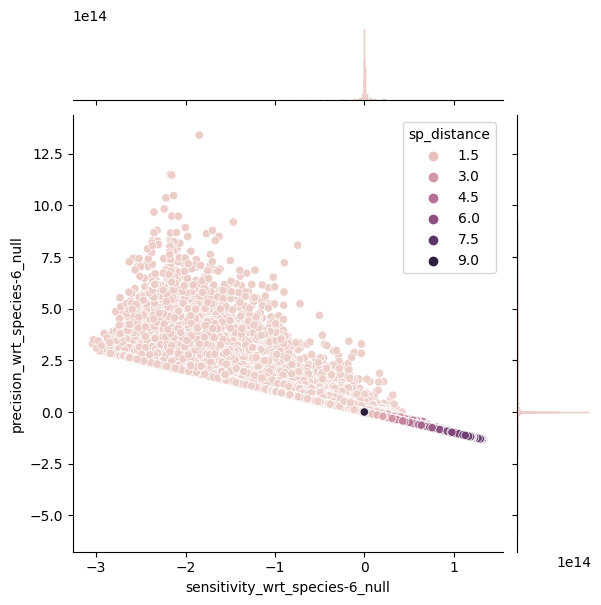

In [ ]:
sns.jointplot(inf, x='sensitivity_wrt_species-6' + '_null', y='precision_wrt_species-6' + '_null', hue='sp_distance')

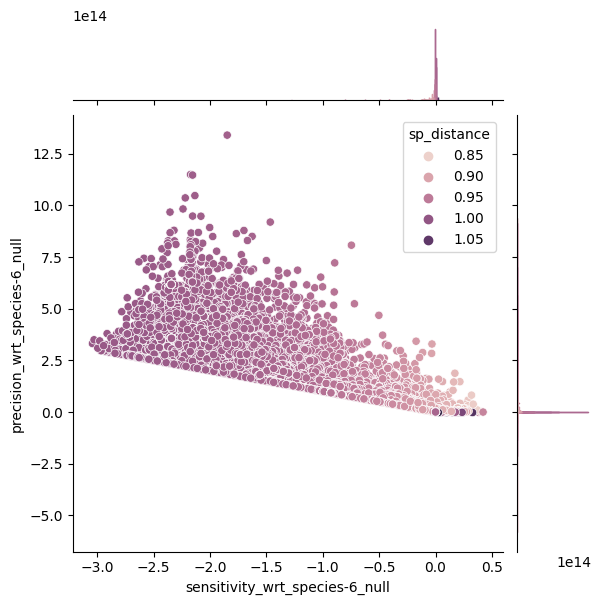

In [ ]:
sns.jointplot(inf[inf['sp_distance'] < 1.1], x='sensitivity_wrt_species-6' + '_null', y='precision_wrt_species-6' + '_null', hue='sp_distance')

Exploring STD's of mutation logs

Text(0.5, 0, 'Sensitivity st. dev.')

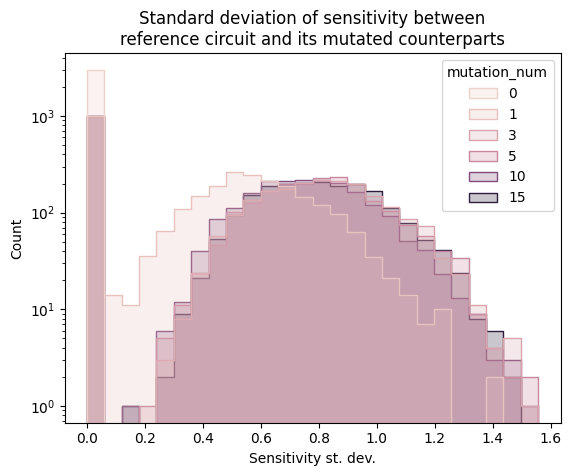

In [ ]:
sns.histplot(mut_summ, x='sensitivity_wrt_species-6' + '_std', hue='mutation_num', log_scale=[False, True], element='step')
plt.title('Standard deviation of log ratio of sensitivity between\nreference circuit and its mutated counterparts')
plt.xlabel('Sensitivity st. dev.')

In [ ]:

named_aggs = {}
for c in mut_summ.columns:
    if c not in ['circuit_name', 'mutation_name', 'sample_name']:
        named_aggs.update({c + '_std': pd.NamedAgg(column=c, aggfunc="std")})
        named_aggs.update({c + '_mean': pd.NamedAgg(column=c, aggfunc="mean")})
        named_aggs.update({c + '_std_normed_by_mean': pd.NamedAgg(column=c, aggfunc=lambda x: np.std(x) / np.max([1, np.mean(x)]))})

mut_summsumm = mut_summ.groupby(['mutation_num', 'sample_name'], as_index=False).agg(**named_aggs)

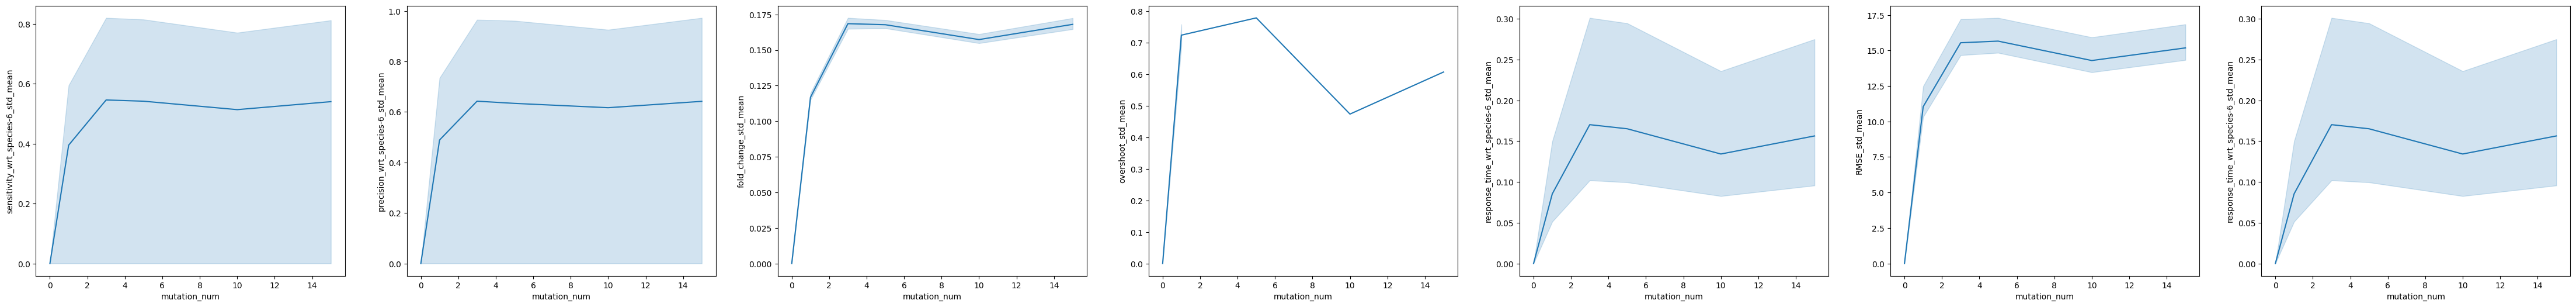

In [ ]:
cols = ['sensitivity_wrt_species-6', 'precision_wrt_species-6', 'fold_change', 'overshoot', 'response_time_wrt_species-6', 'RMSE', 'response_time_wrt_species-6']
cn = len(cols)
plt.figure(figsize=(8*cn, 6))
for i in range(cn):
    ax = plt.subplot(1, cn, i+1)
    sns.lineplot(mut_summsumm,
                x='mutation_num',
                y=cols[i] + '_std_mean')

Now removing null from std's

In [ ]:

named_aggs = {}
for c in relevant_cols:
    named_aggs.update({c + '_std': pd.NamedAgg(column=c, aggfunc=np.nanstd)})
    named_aggs.update({c + '_mean': pd.NamedAgg(column=c, aggfunc=np.nanmean)})
    named_aggs.update({c + '_std_normed_by_mean': pd.NamedAgg(column=c, aggfunc=lambda x: np.nanstd(x) / np.max([1, np.nanmean(x)]))})

infom_mn = deepcopy(infom)
mutation_logmn = deepcopy(mutation_logm)
for c in relevant_cols:
    infom_mn.loc[infom_mn[c + '_null'] == 0, c] = np.nan
    mutation_logmn.loc[infom_mn[c + '_null'] == 0, c] = np.nan

info_summ0 = infom_mn.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg(**named_aggs)
    # {c: [np.std, np.mean, lambda x: np.std(x) / np.mean(x)] for c in relevant_cols})
mut_summ0 = mutation_logmn.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg(**named_aggs)


/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_89048/2438004297.py:5: RuntimeWarning: Mean of empty slice
  named_aggs.update({c + '_std_normed_by_mean': pd.NamedAgg(column=c, aggfunc=lambda x: np.nanstd(x) / np.max([1, np.nanmean(x)]))})
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_89048/2438004297.py:5: RuntimeWarning: Mean of empty slice
  named_aggs.update({c + '_std_normed_by_mean': pd.NamedAgg(column=c, aggfunc=lambda x: np.nanstd(x) / np.max([1, np.nanmean(x)]))})
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1740: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, 

Text(0.5, 0, 'Sensitivity with respect to species-6 standard deviation')

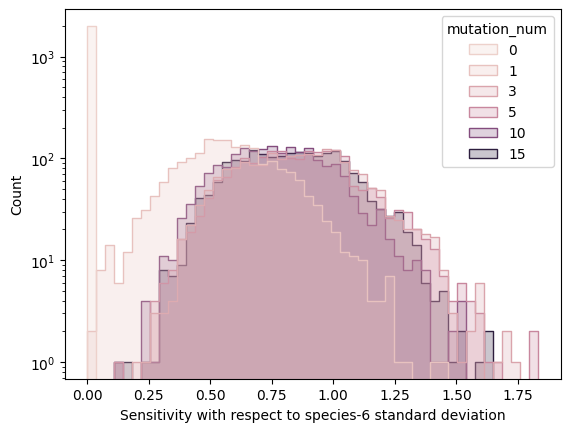

In [ ]:
sns.histplot(mut_summ0, x='sensitivity_wrt_species-6' + '_std', hue='mutation_num', log_scale=[False, True], element='step', bins=50)
plt.xlabel(prettify_keys_for_label('sensitivity_wrt_species-6' + '_std'))


In [ ]:


named_aggs = {}
for c in mut_summ0.columns:
    if c not in ['circuit_name', 'mutation_name', 'sample_name']:
        named_aggs.update({c + '_std': pd.NamedAgg(column=c, aggfunc="std")})
        named_aggs.update({c + '_mean': pd.NamedAgg(column=c, aggfunc="mean")})
        named_aggs.update({c + '_std_normed_by_mean': pd.NamedAgg(column=c, aggfunc=lambda x: np.std(x) / np.max([1, np.mean(x)]))})

stds0 = mut_summ0.groupby(['mutation_num', 'sample_name'], as_index=False).agg(**named_aggs)


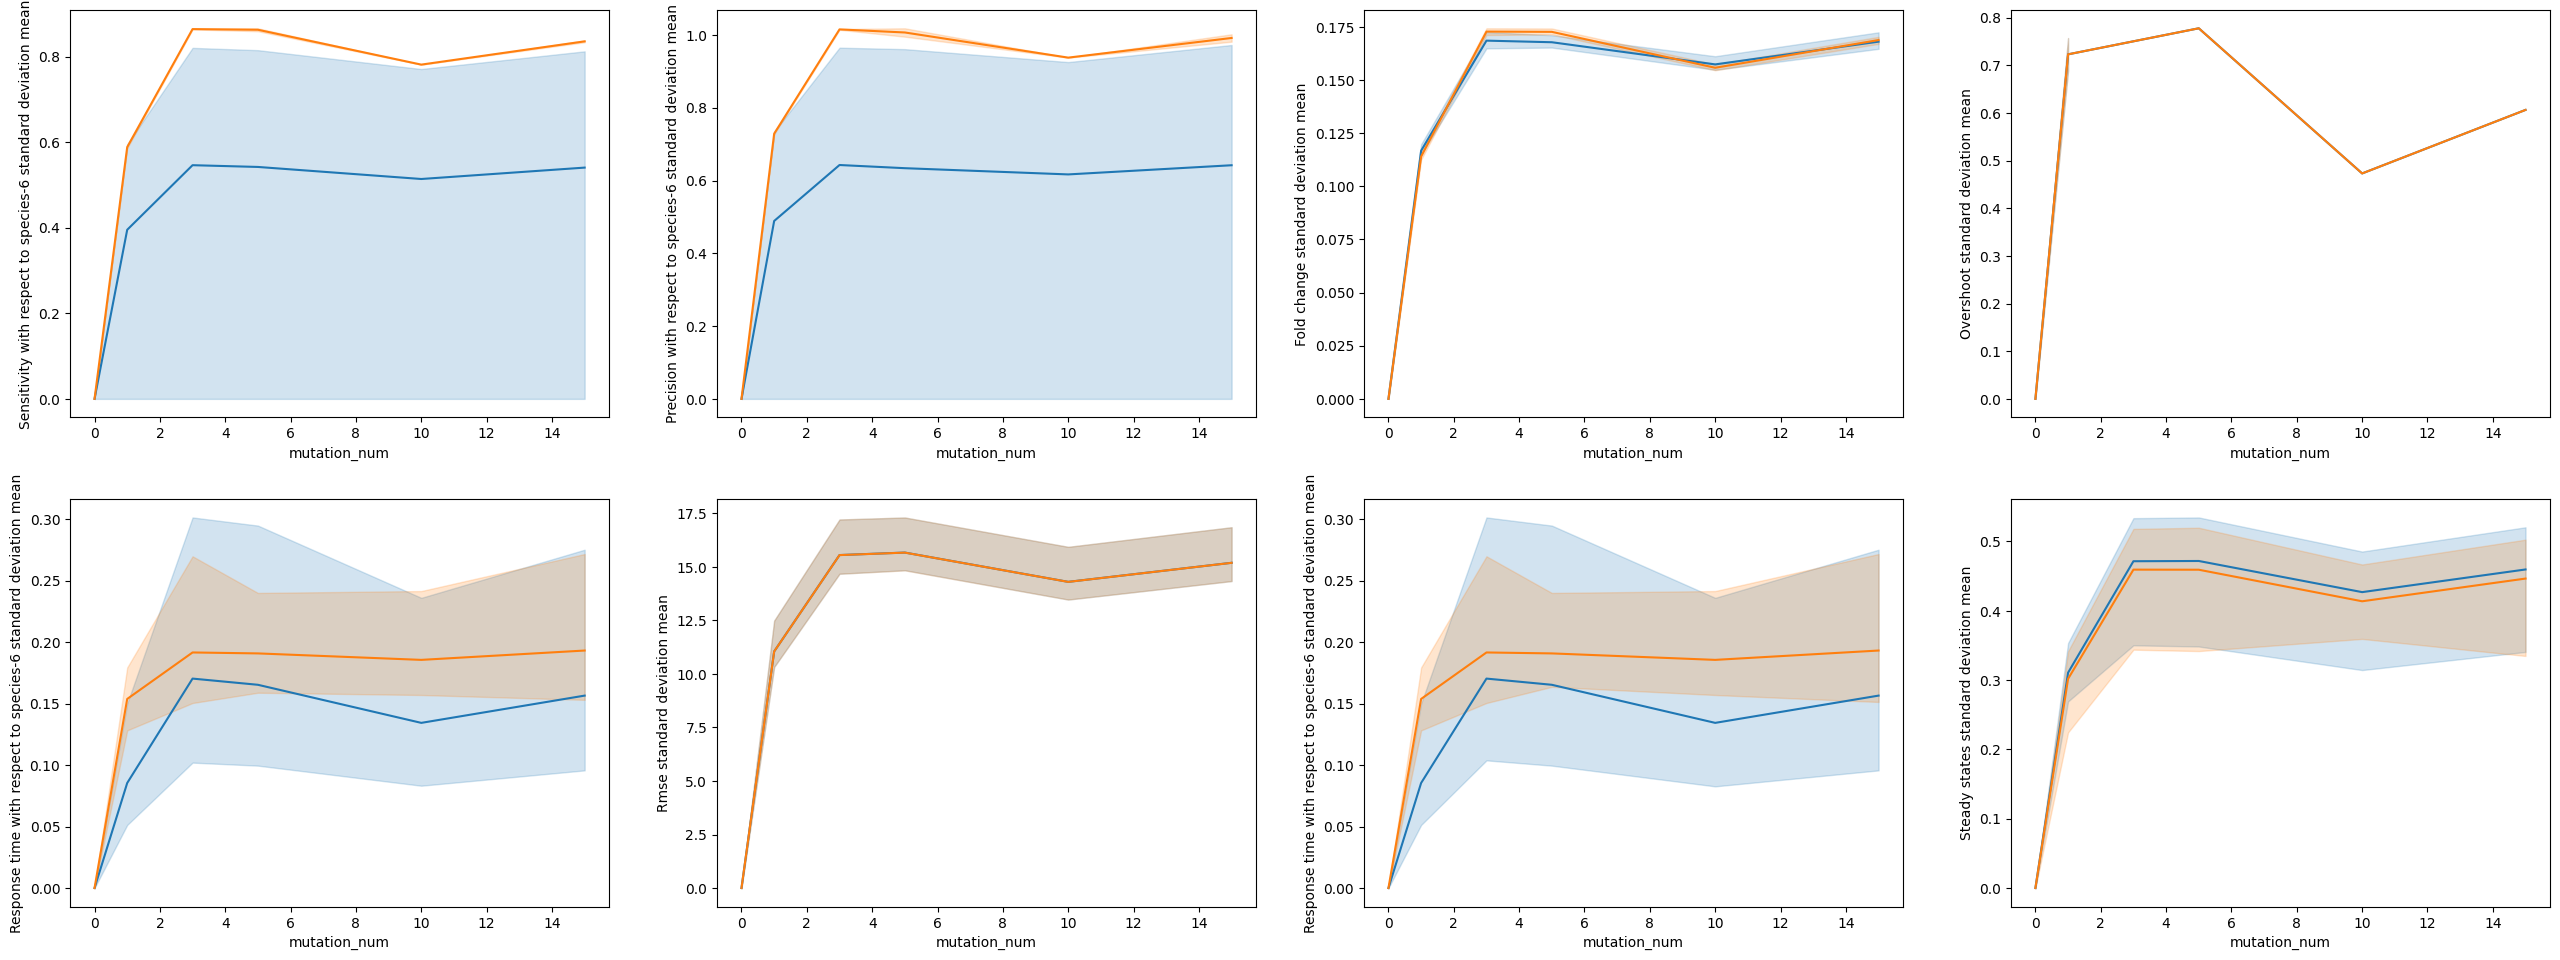

In [ ]:

cols = ['sensitivity_wrt_species-6', 'precision_wrt_species-6', 'fold_change', 'overshoot', 'response_time_wrt_species-6', 'RMSE', 'response_time_wrt_species-6', 'steady_states']
cn = min([len(cols), 4])
rn = int(len(cols)/cn) + 1
plt.figure(figsize=(8*cn, 6*rn))
for i in range(len(cols)):
    ax = plt.subplot(rn, cn, i+1)
    sns.lineplot(mut_summsumm,
                x='mutation_num',
                y=cols[i] + '_std_mean')
    sns.lineplot(stds0,
                x='mutation_num',
                y=cols[i] + '_std_mean')
    plt.ylabel(prettify_keys_for_label(cols[i] + '_std_mean'))


Are the higher mutation circuits approaching the null circuits?

NameError: name 'infom_mn' is not defined

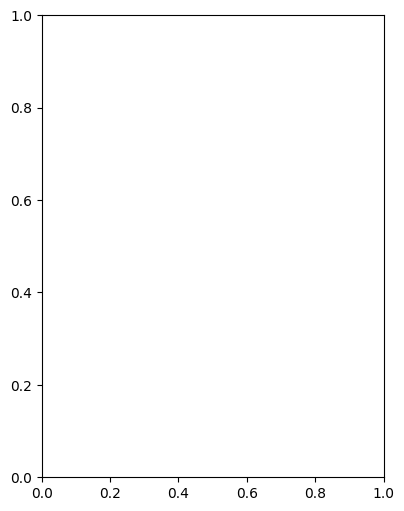

In [ ]:
plt.figure(figsize=(15, 6))

# sns.set_palette('Spectral')
ax = plt.subplot(1,3,1)
sns.histplot(infom_mn, x='energies', hue='mutation_num', element='step', bins=100, log_scale=[False, True])
ax = plt.subplot(1,3,2)
sns.histplot(infom, x='energies', hue='mutation_num', element='step', bins=100, log_scale=[False, True])
ax = plt.subplot(1,3,3)
sns.histplot(x=infom_mn['energies'] - infom['energies'], hue=infom['mutation_num'], element='step', bins=100, log_scale=[False, True])
